In [1]:
import tensorflow as tf
from tensorflow.keras import regularizers, metrics, utils, models
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, Embedding, LSTM, TimeDistributed
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

import os
import re
import nltk
import numpy as np
import pandas as pd
import itertools
import codecs
import pickle
import matplotlib.pyplot as plt
import csv
import zipfile

from sklearn.utils import class_weight 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import OrderedDict
from numpy.random import seed

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
!git clone https://github.com/luciaguasp/DL-terminology-extraction

fatal: destination path 'DL-terminology-extraction' already exists and is not an empty directory.


Descarga los word embeddings de Glove pre-entrenados.

In [11]:
! wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-07-12 13:19:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-07-12 13:19:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-07-12 13:19:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [2]:
with zipfile.ZipFile('glove.6B.zip','r') as zip_ref:
    zip_ref.extractall() 

Para reducir la aleatoriedad de los experimentos (cada evaluación de la ejecución del modelo). 

In [2]:
seed(421)
tf.random.set_seed(123451)

Parámetros que se van a emplear.



In [3]:
# Cambiar en función de lo que se quiera ejecutar
new_model = True           # True: entrena un nuevo modelo. False: carga un modelo ya entrenado y guardado.
save_term_test = False     # Para guardar la terminología obtenida sobre el conjunto de test.
improved_model = True      # True: modelo mejorado (red neuronal más profunda con dos capas BiLSTM). False: modelo con una única capa BiLSTM.
predict = False            # Usa el modelo para predecir terminología de un corpus.
only_predict = False       # Usar un modelo guardado solo para predecir la terminología de un corpus.
new_corpus = False         # True para usar un nuevo corpus (los documentos deben estar en CORPUS_PATH). False para usar el corpus de COVID-19, guardado en un fichero pickle.

In [4]:
# Definir nombre de las rutas
DATASET_PATH = '/content/DL-terminology-extraction/Datasets/INSPEC' # RUTA CON EL DATASET DE ENTRENAMIENTO
EMBEDDING_PATH = 'glove.6B.300d.txt'                                # RUTA CON LOS EMBEDDINGS DE GLOVE (300 DIMENSIONES)
MODEL_PATH = '/content/DL-terminology-extraction/m2_BiLSTM_glove'   # RUTA DONDE GUARDAR LOS MODELOS ENTRENADOS

if save_term_test:
    TERM_PATH_INSPEC = '/content/DL-terminology-extraction/Terminology/m2_INSPECterminology.csv' # RUTA DONDE GUARDAR LA TERMINOLOGÍA GENERADA
    
if predict:
    CORPUS_PATH = '/content/DL-terminology-extraction/Datasets/COVID'                            # RUTA CON EL CORPUS DE PREDICCIÓN
    TERM_PATH_CORPUS = '/content/DL-terminology-extraction/Terminology/m2_COVIDterminology.csv'  # RUTA DONDE SE GUARDA LA TERMINOLOGÍA DEL CORPUS
    VOCABULARY_PATH = '/content/DL-terminology-extraction/Embeddings/vocabulary_trained.pickle'  # VOCABULARIO CREADO CON LOS DOCUMENTOS DE INSPEC

In [5]:
MAX_SEQUENCE_SIZE = 550      # máximo tamaño de los docmentos
MAX_VOCABULARY_SIZE = 20000  # máxima cantidad de palabras del vocabulario               
EMBEDDINGS_SIZE = 300        # tamaño de los word embeddings
BATCH_SIZE = 32              # tamaño de los batchs de entrenamiento
EPOCHS = 30                  # nº de épocas

# Clases y funciones

## **Funciones generales y de pre-proceso**

Función para obtener los documentos del Dataset estructurados. Los guarda en un diccionario donde la clave es el nombre de cada documento y el valor el contenido de cada documento.

Entrada: ruta con los documentos del dataset.
Salidas: 
* input_doc: diccionario con el nombre de los documentos como clave, el texto como valor. Serán las entradas del modelo, tras ser preprocesadas.
* output_term: diccionario con el nombre de los documentos como clave, la terminología como valor. Será la salida del modelo.

In [6]:
def load_dataset(path):

        input_doc = {}    # diccionario que contendrá el nombre de los documentos como clave y su contenido como valor
        output_term = {}  # diccionario que contendrá la terminología que se quiere extraer en los documentos
        
        for doc in os.listdir(path):
            doc_file = path + '/' + str(doc)
            if doc.endswith(".abstr"):                   # los documentos enteros son aquellos que acaban en .abstr
                text = codecs.open(doc_file, "r", encoding='utf-8', errors='ignore').read()
                input_doc[doc[:doc.find('.')]] = text    # la clave será el nombre del documento sin la extensión (hasta el .)
            elif doc.endswith(".uncontr"):               # la terminología está contenida en los archivos .uncontr (no controlada) o .contr (controlada)
              text = open(doc_file, "rt").read() 
              terms = text.split(';')
              doc_name = doc[:doc.find('.')]
              for term in terms:
                  term = term.strip()
                  if doc_name not in output_term:
                      output_term[doc_name] = [term]
                  else:
                      output_term[doc_name].append(term)
          
        return input_doc, output_term

In [7]:
def load_corpus(path):

        corpus = {}    # diccionario que contendrá el nombre de los documentos como clave y su contenido como valor
        for doc in os.listdir(path):
            doc_file = path + '/' + str(doc)
            text = codecs.open(doc_file, "r", encoding='utf-8', errors='ignore').read()
            corpus[doc[:doc.find('.')]] = text    # la clave será el nombre del documento sin la extensión (hasta el .)
          
        pickle.dump(corpus, open(path, "wb"))  
        return corpus

Clase para construir un vocabulario que pueda emplearse en una capa tipo "Embedding layer" con word embeddings.

In [8]:
class Vocabulary(object):

    def __init__(self, voc_length = None):

        self.word_freq = OrderedDict()   # diccionario que recuerda el orden de inserción de las palabras. Devuelve 1º las claves que se añadieron 1º. Clave: palabra. Valor: nº de veces que aparece.
        self.word_index = {}             # diccionario normal
        self.voc_length = voc_length     # para limitar el tamaño que queremos observar del diccionario

    def new_vocabulary(self, tokenized_docs):  # función para obtener el diccionario de unos documentos pasados como parámetro tokenizados

        for doc in tokenized_docs:
            for tok in doc:                    # contador de tokens
                if tok in self.word_freq:
                    self.word_freq[tok] += 1   # si la palabra ya estaba en el diccionario, se incrementa el contador
                else:
                    self.word_freq[tok] = 1    # si no esta, se inicializa (es la priemra vez que aparece la palabra)

        word_freq_ls = list(self.word_freq.items())              # convierte el diccionario en lista
        word_freq_ls.sort(key = lambda x: x[1], reverse = True)  # ordena la lista, en primer lugar las palabras que aparecen más frecuentemente
        sorted_voc = [word[0] for word in word_freq_ls]          # lista que contiene las claves (palabras) ordenadas, pero sin los valores
                                                                 # el índice 0 nunca se asigna a una palabra
        self.word_index = dict(list(zip(sorted_voc, list(range(1, len(sorted_voc) + 1))))) # nuevo diccionario donde aparecen las palabras (claves) ordenadas y el valor es ascendente (la palabra más frecuente tiene valor 1, la 2º el 2...)


    def texts_to_word_sequence(self, documents):  # documents será un diccionario, donde la clave es el nombre del documento y el valor el texto tokenizado

        word_sequence = []
        for doc in documents:                     # para cada uno de los documenots
            seq = []
            for word in doc:
                index = self.word_index.get(word)    # obtiene la posición de la palabra en el diccionario creado
                if index is not None:                 # solo si el token pertenece al diccionario
                    if self.voc_length and index >= self.voc_length: # si la palabra se encuentra más allá del alcance definido del diccionario
                        continue
                    else:
                        seq.append(index)         # se añade la palabra a la lista

            word_sequence.append(seq)

        return word_sequence

Función para tokenizar los documentos y las etiquetas (terminología).

In [9]:
def tokenize(documents, terminology = False):
    tokenized_text = {}
    for doc, text in documents.items():
        if terminology == False:
            tokenized_text[doc] = nltk.word_tokenize(text.lower()) 
        else:
            for term in text:
                if doc not in tokenized_text:
                    tokenized_text[doc] = [nltk.word_tokenize(term.lower())] 
                else:
                    tokenized_text[doc].append(nltk.word_tokenize(term.lower())) 

    return tokenized_text

In [10]:
# Eliminando puntuación y stopwords
def tokenize_text_clean(documents):
    nltk.download('stopwords')
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_text = {}
    for doc, text in documents.items():
        sentence_tok = tokenizer.tokenize(text.lower())

        sentence_tok_noSW = []
        for token in sentence_tok:
            if token not in set(stopwords.words('english')):
                sentence_tok_noSW.append(token)
                
        tokenized_text[doc] = sentence_tok_noSW

    return tokenized_text

Función para modificar las salidas del modelo en forma clasificatoria: indica con un 0 las palabras que no corresponden a ningún término, 1 si es el inicio de un término, 2 si pertenece a uno.
*   Entradas: 
  * texts: diccionario con el nombre del documento como clave y el texto tokenizado como valor.
  * terms: diccionario con el nombre del documento como clave y la terminología tokenizada como valor.
*   Salida: 
  * seq_terms: diccionario con el nombre del documento como clave. El valor indica la clase de cada una de las palabras del documento (0, 1 ó 2).

In [11]:
def to_sequential(texts, terms):              # las entradas son diccionarios

    seq_terms = {}

    for key, text in texts.items():                    # bucle por documentos
        current_terminology = terms[key]               # doc_answers_set: lista con las respuestas del documento actual
        current_terminology.sort(key=lambda a: len(a)) # ordena por longitud de los términos. 1º se procesan los más cortos, de manera que si están contenidos en uno más largo, se quedama con el largo
        current_term_seq = [0] * len(text)              # secuencia con las clases de todas las palabras del documento, se inicializa como una lista todo a 0s (nada es KP)

        for term in current_terminology:             # bucle por palabras pertenecientes a términos
            appearances = [i for i, word in enumerate(text) if word == term[0]] # encuentra dónde aparecen las primeras palabras correspondientes a un término (answer[0])
            for idx in appearances:                   # bucle de los índices correspondientes a inicios de términos
                is_kp = True                          # determina que se encuentra dentro de un término 
                for i in range(1, len(term)):       # bucle de los índices de respuestas etiquetadas
                    if (i + idx) < len(text):
                        is_kp = term[i] == text[i + idx]  # comprueba si el término coincide con las siguientes palabras
                    else:                             # se ha alcanzado el final del documento, por lo que acaba el término
                        is_kp = False               

                if is_kp:                             # cuando se ha encontrado un término
                    current_term_seq[idx] = 1          # se determina la primera palabra con la clase 1
                    for i in range(1, len(term)):
                        current_term_seq[idx + i] = 2  # el resto de palabras pertenecientes se identifican con la clase 2

        seq_terms[key] = current_term_seq            # se guarda la lista con las clases de los tokens de cada documento en un diccionario

    return seq_terms

Transforma una lista bidimensional en un vector tridimensional.


*   Entrada: vector numpy 2D (nº docs x max_document_length). Representa todas las palabras de los documentos etiquetadas según su clase (0, 1 ó 2).
*   Salida: vector numpy 3D (nº docs x max_document_length x nº clases). Representa todas las palabras de los documentos etiquetadas según su clase, mediante un vector se indica la clase correspondiente. Ej clase 0: [1 0 0] 



In [12]:
def to_categorical(labels):
    num_classes = 3
    new_labels = np.zeros((len(labels), len(labels[0]), num_classes))        # prepara el vector para la forma tridimensional
    i = 0
    for doc in labels:
        new_doc = utils.to_categorical(doc, num_classes = num_classes)       # transforma a la forma categórica
        new_labels[i] = new_doc
        i += 1

    return new_labels

Función para el preproceso del corpus. Prepara el dataset como entrada de un modelo secuencial y de clasificación.
*   Entradas: 
  * train_text_tok, test_doc, val_doc: diccionario con el nombre del documento como clave, el texto tokenizado como valor.
    * train_answer, test_answer, val_answer: diccionario con el nombre del documento como clave, los términos tokenizados como valor.
*   Salidas: 
    * train_x, test_x, val_x: vectores numpy 2D (nº docs x max_document_length). Representa cada palabra con un entero.
    * train_y, test_y, val_y: vectores numpy 3D (nº docs x max_document_length x nº clases). Representa la clase de cada una de las palabras de los documentos.
    * embedding_matrix: vector numpy 2D (nº palabras del diccionario x long word embeddings)
    * vocabulary: objeto Vocabulary con el vocabulario específico de los documentos.

In [13]:
def preprocessing(train_text, train_term, test_text, test_term, val_text, val_term,
                       max_sequence_size = 550,
                       max_vocabulary_size = 50000, # tamaño máximo del diccionario que se crea con el vocabulario de todos los documentos
                       embeddings_size = 300):
    # Transformar las respuestas (terminología) en etiquetas de las clases (0: no KP, 1: inicio KP, 2: pertenece a KP)
    train_term_seq = to_sequential(train_text, train_term)
    test_term_seq = to_sequential(test_text, test_term)
    val_term_seq = to_sequential(val_text, val_term)

    # Prepara los datos de validación que se devolverán
    val_x = None
    val_y = None

    # Transforma los documentos a secuencias
    vocabulary_texts = [] # almacena el vocabulario de todos los documentos
    train_y = []          # almacena las etiquetas de las clases
    test_y = []
    val_y = []

    for key, doc in train_text.items():
        vocabulary_texts.append(token for token in doc)
        train_y.append(train_term_seq[key])
    for key, doc in test_text.items():
        vocabulary_texts.append(token for token in doc)
        test_y.append(test_term_seq[key])
    for key, doc in val_text.items():
        vocabulary_texts.append(token for token in doc)
        val_y.append(val_term_seq[key])

    vocabulary = Vocabulary(voc_length = max_vocabulary_size)
    vocabulary.new_vocabulary(vocabulary_texts) # crea un diccionario con el vocabulario de todos los textos (entrenamiento, test y validación)

    # Prepara las entradas del modelo en base al diccionario creado con el vocabulario. Transforma el texto (tokens) en secuencias
    train_x = vocabulary.texts_to_word_sequence(train_text.values())
    test_x = vocabulary.texts_to_word_sequence(test_text.values())
    val_x = vocabulary.texts_to_word_sequence(val_text.values())

    # pad_sequences transforma  una lista de secuencias en un vector 2D
    # Now we map the sentences to a sequence of numbers and then pad the sequence. 
    # Note that we increased the index of the words by one to use zero as a padding value. 
    # This is done because we want to use the mask_zero parameter of the embedding layer to ignore inputs with value zero.

    train_x = np.asarray(pad_sequences(train_x, maxlen=max_sequence_size, padding='post', truncating='post'))
    train_y = pad_sequences(train_y, maxlen=max_sequence_size, padding='post', truncating='post')
    train_y = to_categorical(train_y)

    test_x = np.asarray(pad_sequences(test_x, maxlen=max_sequence_size, padding='post', truncating='post'))
    test_y = pad_sequences(test_y, maxlen=max_sequence_size, padding='post', truncating='post')
    test_y = to_categorical(test_y)

    val_x = np.asarray(pad_sequences(val_x, maxlen=max_sequence_size, padding='post', truncating='post'))
    val_y = pad_sequences(val_y, maxlen=max_sequence_size, padding='post', truncating='post')
    val_y = to_categorical(val_y)

    # Prepara la matriz de entrada de la "embedding layer"
    word_index = vocabulary.word_index  # diccionario con el vocabulario
    embeddings_index = {}               # diccionario con los valores de los word embeddings. Clave: palabra. Valor: coeficiente de los word embeddings.

    f = open(EMBEDDING_PATH)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    voc_length = min(max_vocabulary_size, 1 + len(word_index))  # el nº de palabras del vocabulario será el tamaño del diccionario creado, si no sobrepasa el máximo. 
    embedding_matrix = np.zeros((voc_length, embeddings_size))  # matriz filas (palabras del vocabulario) y columnas (tamaño de los word embeddings)
    for word, i in word_index.items():
        if i >= voc_length:  # si sobrepasa el tamaño del vocabulario
            continue
        embedding_vector = embeddings_index.get(word) # devuelve el valor del diccionario (coef) dada la clave (palabra)
        if embedding_vector is not None:              # las palabras que no estén en los word embeddings serán 0s
            embedding_matrix[i] = embedding_vector

    return train_x, train_y, test_x, test_y, val_x, val_y, embedding_matrix, vocabulary


Función para el preproceso del corpus, en el caso de que solo se tenga entrada. Se empleará, por tanto, a la hora de predecir la terminología de un texto sin etiquetar.

In [14]:
def preprocessing_predict_corpus(documents, vocabulary, max_sequence_size = 550): 

    x = vocabulary.texts_to_word_sequence(documents.values())
    x = np.asarray(pad_sequences(x, maxlen = max_sequence_size, padding='post', truncating='post'))  

    return x

Clase para generar callbacks que aporten información de la precisión, el recall y la métrica f1 durante las distintas épocas del entrenamiento.


In [15]:
class Metric_Callback(tf.keras.callbacks.Callback):

    def __init__(self,val_x,val_y):
        self.val_x = val_x
        self.val_y = val_y
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs={}):

        y_pred = self.model.predict(self.val_x)
        precision_ = precision(self.val_y,y_pred)
        recall_ = recall(self.val_y, y_pred)
        f1_ = f1(self.val_y, y_pred)

        print("")
        print("Métricas de validación:") 
        print("Época     : {}".format(epoch+1))
        print("Precisión : {}".format(precision_))
        print("Recall    : {}".format(recall_))
        print("F1        : {}".format(f1_))

        self.epoch.append(epoch+1)
        self.history.setdefault("precision", []).append(precision_)
        self.history.setdefault("recall", []).append(recall_)
        self.history.setdefault("f1", []).append(f1_)

## **Post-procesado**

Obtención de las palabras que el modelo selecciona como KP (categorías 1 ó 2). Devuelve un diccionario donde la clave es el documento y el valor es una lista con las KP de dicho documento.

In [16]:
def obtain_words(docs, category_prediction):

    doc_count = 0 
    obtained_words = {}
    for doc, words in docs.items():
        token_count = 0  
        obtained_words_doc = []   # lista con las palabras obtenidas de cada documentos
        in_word = False           # para asegurar que el primer token que selecciona como KP sea inicio (1)
        for token in category_prediction[doc_count]:
            if token == 1 and token_count < len(words):
                obtained_words_doc.append([words[token_count]])
                in_word = True    # después de encontrar un inicio (1), ya puede aparecer un 2
            elif token == 2 and token_count < len(words) and in_word:
                obtained_words_doc[len(obtained_words_doc) - 1].append(words[token_count])
            else:
                in_word = False
            token_count += 1

        # Eliminar duplicados 
        obtained_words_doc.sort()
        obtained_words_doc = list(w for w, _ in itertools.groupby(obtained_words_doc))
        obtained_words[doc] = obtained_words_doc
        doc_count += 1

    return obtained_words

Función para generar un DataFrame y un fichero csv con la terminología, el documento asociado a cada término y su frecuencia en dicho documento.

Entradas: 
* obtained_words: diccionario con el nombre de los documentos como clave, la terminología asociada como valor.
* corpus_path: ruta donde se encuentran los documentos del corpus sobre el que se ha extraído la terminología.
* save_term_path: ruta donde se quiere guardar el fichero csv con el DataFrame.

Salida: DataFrame generado.

In [17]:
def create_df_file(obtained_words, corpus_path, save_term_path, clean_terminology = True):
    df = pd.DataFrame(columns=['keyword', 'doc_id', 'Frecuencia'])

    index = 0
    for doc in obtained_words:   # bucle por cada documento

        doc_name = doc + '.abstr'
        path = corpus_path + '/' + doc_name
        with open(path) as file:
            text = file.read().lower()    # se guarda el contenido del documento
            text = text.replace('\n', '')
            text = text.replace('\t', ' ')

        for term in obtained_words[doc]: # bucle por cada término (dentro de cada documento)
            term_str = ' '.join(term)

            if clean_terminology:
                sw = stopwords.words('english')
                term_list = re.findall("([a-z0-9/']+)", term_str, re.I) # para seleccionar únicamente letras y números
                term_str = ' '.join(term_list)
                if len(term_str) < 2 or term_str in sw:   # si un término solo tiene menos de 2 caracteres o es una sw, no se almacena
                    continue 

            freq = text.count(term_str)           # se cuenta la frecuencia de los términos
            
            df.loc[index] = [term_str, doc, freq] 
            index += 1

    df.to_csv(save_term_path, index=False) # se guarda el fichero
    
    return df

Para el corpus de Airbus y del COVID.

In [18]:
def create_df_file_corpus(obtained_words, corpus, save_term_path):
    df = pd.DataFrame(columns=['keyword', 'doc_id', 'Frecuencia'])
    sw = stopwords.words('english')

    index = 0
    for doc in obtained_words:   # bucle por cada documento

        text = corpus[doc]
        text = text.replace('\n', '')
        text = text.replace('\t', ' ')

        for term in obtained_words[doc]: # bucle por cada término (dentro de cada documento)
            term_str = ' '.join(term)
            term_list = re.findall("([a-z0-9/']+)", term_str, re.I) # para seleccionar únicamente letras y números
            term_str = ' '.join(term_list)

            if len(term_str) < 2 or term_str in sw: # filtrar los términos vacíos, con 1 sola letra o que únicamente es una stopword
                continue

            freq = text.count(term_str)           # se cuenta la frecuencia de los términos
            
            df.loc[index] = [term_str, doc, freq] 
            index += 1

    df.to_csv(save_term_path, index=False) # se guarda el fichero
    
    return df

## **Evaluación**

Funciones para obtener la precisión, el recall y la métrica f1 de las predicciones.

In [19]:
def precision(y_true_in, y_pred_in) :

    true_positives = 0
    false_positives = 0

    # Reducir la dimensión (de 3D a 2D)
    y_true = np.argmax(y_true_in, axis=2)
    y_pred = np.argmax(y_pred_in, axis=2)

    y_true_index = {}
    for i in range(np.shape(y_true)[0]):
        doc_true_index = []
        in_word = False
        for j in range(np.shape(y_true)[1]):
            if y_true[i][j] == 1 :
                doc_true_index.append(["%s" % j])
                in_word = True
            elif j > 0 and y_true[i][j] == 2 and in_word:
                doc_true_index[len(doc_true_index) -1].append(",%s" % j)
            else:
                in_word = False

        y_true_index[i] = doc_true_index

    y_pred_index = {}
    for i in range(np.shape(y_pred)[0]):
        doc_true_index = []
        in_word = False
        for j in range(np.shape(y_pred)[1]):
            if y_pred[i][j] == 1:
                doc_true_index.append(["%s" % j])
                in_word = True
            elif j > 0 and y_pred[i][j] == 2 and in_word:
                doc_true_index[len(doc_true_index) - 1].append(",%s" % j)
            else :
                in_word = False

        y_pred_index[i] = doc_true_index

    for i in range(len(y_pred_index)) :
        for kp in y_pred_index[i]:
            if kp in y_true_index[i]:
                true_positives += 1
            else :
                false_positives += 1

    if true_positives + false_positives > 0:
        precision = (true_positives * 1.0) / (true_positives + false_positives)
    else: precision = 0
    return precision

In [20]:
def recall(y_true_in, y_pred_in) :

    true_positives = 0
    false_positives = 0

    # Para reducir la dimensión (pasa de 3D a 2D)
    y_true = np.argmax(y_true_in, axis=2)
    y_pred = np.argmax(y_pred_in, axis=2)

    y_true_index = {}

    for i in range(np.shape(y_true)[0]):
        doc_true_index = []
        in_word = False

        for j in range(np.shape(y_true)[1]):
            if y_true[i][j] == 1 :
                doc_true_index.append(["%s" % j])
                in_word = True
            elif j > 0 and y_true[i][j] == 2 and in_word:
                doc_true_index[len(doc_true_index) -1].append(",%s" % j)
            else:
                in_word = False

        y_true_index[i] = doc_true_index

    y_pred_index = {}

    for i in range(np.shape(y_pred)[0]):
        doc_true_index = []
        in_word = False
        for j in range(np.shape(y_pred)[1]):

            if y_pred[i][j] == 1:
                doc_true_index.append(["%s" % j])
                in_word = True
            elif j > 0 and y_pred[i][j] == 2 and in_word:
                doc_true_index[len(doc_true_index) - 1].append(",%s" % j)
            else :
                in_word = False

        y_pred_index[i] = doc_true_index

    for i in range(len(y_pred_index)) :
        for kp in y_pred_index[i]:
            if kp in y_true_index[i]:
                true_positives += 1

    return (1.0 * true_positives) / sum(len(kps) for doc,kps in y_true_index.items())

In [21]:
def f1(y_true, y_pred):

    precisionx = precision(y_true, y_pred)
    recallx = recall(y_true, y_pred)
    if precisionx != 0 and recallx != 0:
      f1_score = (2 * (precisionx * recallx)) / (precisionx + recallx)
    else: f1_score = 0
    return  f1_score

# Pre-proceso. Preparación del modelo

Estructuración del corpus en distintos diccionarios, distinguiendo entre entrenamiento, test y validación, así como los textos y sus salidas deseadas (la terminología).

In [22]:
if only_predict == False:
    train_text, train_term = load_dataset("{}/train".format(DATASET_PATH))
    test_text, test_term = load_dataset("{}/test".format(DATASET_PATH))
    val_text, val_term = load_dataset("{}/val".format(DATASET_PATH))

Tokenización de los diccionarios sobre los documentos obtenidos en el paso anterior,

In [25]:
if only_predict == False:  
    train_text_tok = tokenize(train_text)
    train_term_tok = tokenize(train_term, terminology = True)

    test_text_tok = tokenize(test_text)
    test_term_tok = tokenize(test_term, terminology = True)

    val_text_tok = tokenize(val_text)
    val_term_tok = tokenize(val_term, terminology = True)

Preparación de las entradas para el modelo secuencial con word embeddings. 

In [26]:
if only_predict == False: 
    train_x, train_y, test_x, test_y, val_x, val_y, embedding_matrix, vocabulary_trained = preprocessing(
                          train_text_tok, train_term_tok, test_text_tok, test_term_tok, val_text_tok, val_term_tok,
                          max_sequence_size = MAX_SEQUENCE_SIZE,
                          max_vocabulary_size = MAX_VOCABULARY_SIZE,
                          embeddings_size = EMBEDDINGS_SIZE)

# Modelo

In [27]:
tf.keras.backend.clear_session()

In [28]:
if new_model == True and only_predict == False:     
    # da mayor peso a las clases que no son 0, es decir, a las palabras pertenecientes a KP
    train_y_weights = np.argmax(train_y, axis=2) # devuelve los índices de los valores máximos en el eje 2 
    train_y_weights = np.reshape(class_weight.compute_sample_weight('balanced', train_y_weights.flatten()), np.shape(train_y_weights))

In [29]:
if new_model == True and only_predict == False:     
    model = Sequential()
    embedding_layer = Embedding(np.shape(embedding_matrix)[0],        # input_dim = 11261, tamaño del vocabulario
                                    EMBEDDINGS_SIZE,                  # output_dim, tamaño de los word embeddings
                                    weights = [embedding_matrix],     # concatenación de la lista de pesos
                                    input_length = MAX_SEQUENCE_SIZE, # tamaño de las secuencias de entrada
                                    trainable = False)                # no se entrenan con mi corpus, sino que se usan los de GloVE

In [30]:
if new_model == True and only_predict == False: 
    if improved_model:
        model.add(embedding_layer)
        model.add(Bidirectional(LSTM(200, activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=True)))
        model.add(Dropout(0.25))
        model.add(Bidirectional(LSTM(200, activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=True)))
        model.add(Dropout(0.25))
        model.add(TimeDistributed(Dense(150, activation='relu', kernel_regularizer=regularizers.l2(0.01))))
        model.add(Dropout(0.25))
        model.add(TimeDistributed(Dense(3, activation='softmax'))) # softmax, clasificación multiclase, con 3 clases (salidas)
    else:        
        model.add(embedding_layer)
        model.add(Bidirectional(LSTM(300, activation='tanh', recurrent_activation='hard_sigmoid', return_sequences=True)))
        model.add(Dropout(0.25))
        model.add(TimeDistributed(Dense(150, activation='relu', kernel_regularizer=regularizers.l2(0.01))))
        model.add(Dropout(0.25))
        model.add(TimeDistributed(Dense(3, activation='softmax'))) # softmax, clasificación multiclase, con 3 clases (salidas)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'],
                      sample_weight_mode="temporal")
    # model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'],
    #                 sample_weight_mode="temporal")
    print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 550, 300)          5501100   
_________________________________________________________________
bidirectional (Bidirectional (None, 550, 400)          801600    
_________________________________________________________________
dropout (Dropout)            (None, 550, 400)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 550, 400)          961600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 550, 400)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 550, 150)          60150     
_________________________________________________________________
dropout_2 (Dropout)          (None, 550, 150)          0

In [31]:
if new_model == True and only_predict == False:     
    metrics_callback = Metric_Callback(val_x, val_y)
    
    history = model.fit(train_x, train_y,
                            validation_data=(val_x, val_y),
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            sample_weight=train_y_weights, 
                            callbacks=[metrics_callback])

Epoch 1/30
32/32 [==============================] - ETA: 0s - loss: 2.2090 - accuracy: 0.7605
Métricas de validación:
Época     : 1
Precisión : 0.03366770179397243
Recall    : 0.3328180212014134
F1        : 0.061149546551969
32/32 [==============================] - 126s 4s/step - loss: 2.2090 - accuracy: 0.7605 - val_loss: 1.1680 - val_accuracy: 0.8248
Epoch 2/30
32/32 [==============================] - ETA: 0s - loss: 0.9392 - accuracy: 0.8642
Métricas de validación:
Época     : 2
Precisión : 0.17899389054985052
Recall    : 0.6082155477031802
F1        : 0.2765893341367882
32/32 [==============================] - 125s 4s/step - loss: 0.9392 - accuracy: 0.8642 - val_loss: 0.5569 - val_accuracy: 0.9221
Epoch 3/30
32/32 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.9067
Métricas de validación:
Época     : 3
Precisión : 0.20826185411377204
Recall    : 0.670273851590106
F1        : 0.317784409193236
32/32 [==============================] - 124s 4s/step - loss: 0.4

In [32]:
if new_model == True and only_predict == False:     
    models.save_model(model, MODEL_PATH)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/DL-terminology-extraction/m2_BiLSTM_glove/assets


Se muestra la gráfica del accuracy en función de la epoch.

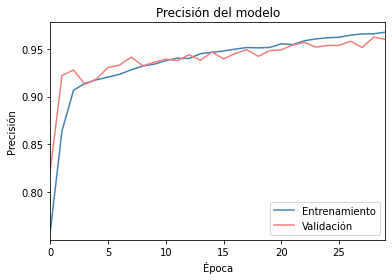

In [33]:
if new_model == True and only_predict == False:   
    f = plt.figure()    
    plt.xlim(0, 29)
    plt.plot(history.history['accuracy'], color = 'steelblue')
    plt.plot(history.history['val_accuracy'], color = 'lightcoral')
    plt.title('Precisión del modelo')
    plt.ylabel('Precisión')
    plt.xlabel('Época')
    plt.legend(['Entrenamiento', 'Validación'], loc='lower right')
    plt.show()

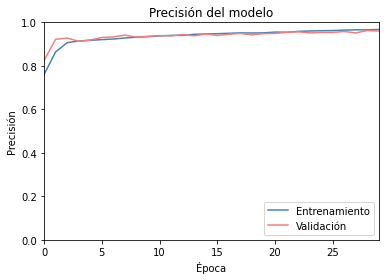

In [34]:
if new_model == True and only_predict == False:     
    f = plt.figure()  
    plt.ylim(0, 1)
    plt.xlim(0, 29)

    plt.plot(history.history['accuracy'], color = 'steelblue')
    plt.plot(history.history['val_accuracy'], color = 'lightcoral')
    plt.title('Precisión del modelo')
    plt.ylabel('Precisión')
    plt.xlabel('Época')
    plt.legend(['Entrenamiento', 'Validación'], loc='lower right')
    plt.show()

Gráfica de la función de coste.

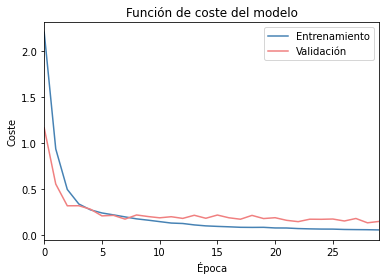

In [35]:
if new_model == True and only_predict == False:  
    f = plt.figure()   
    plt.xlim(0, 29)
    plt.plot(history.history['loss'], color = 'steelblue')
    plt.plot(history.history['val_loss'], color = 'lightcoral')
    plt.title('Función de coste del modelo')
    plt.ylabel('Coste')
    plt.xlabel('Época')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
    plt.show()

# Evaluación test

Se carga el modelo y se predicen los resultados con el corpus de test.

In [36]:
if only_predict == False:
    model = models.load_model(MODEL_PATH)

El vector que se obtiene con la predicción (output_test) selecciona los 400 tokens de cada uno de los 100 documentos en las 3 categorías posibles. Obtiene la probabilidad de pertenecer a cada una de las categorías.

In [37]:
if only_predict == False:
    output_test = model.predict(x=test_x, verbose=1)

16/16 [==============================] - 12s 766ms/step


Se transforma el vector en 3D obtenido por otro en 2D que indique la categoría de cada uno de los 400 tokens de los 100 documentos. En cada token, nos quedamos con la categoría que tiene una mayor probabilidad.

In [38]:
if only_predict == False:
    obtained_tokens_test = np.argmax(output_test,axis=2)

Obtención de las palabras indicadas como KP (1 ó 2). Se obtiene un diccionario donde la clave es el documento y el valor es la lista con las KP de dicho documento.



In [39]:
if only_predict == False:
    obtained_words_test = obtain_words(test_text_tok, obtained_tokens_test)

In [40]:
if only_predict == False:
    test_precision = precision(test_y, output_test)
    test_recall = recall(test_y, output_test)
    test_f1 = f1(test_y, output_test)
    print("MÉTRICAS SOBRE TEST \nPrecisión: {}\nRecall: {}\nf1: {}".format(test_precision, test_recall, test_f1))

MÉTRICAS SOBRE TEST 
Precisión: 0.373905940016338
Recall: 0.6672219908371512
f1: 0.4792461296836437


# Generar fichero csv con la terminología test

Se genera el DataFrame y el fichero csv en el que se encuentra la terminología, el documento del que procede y la frecuencia en dicho documento.

In [ ]:
if save_term_test:    
    inspec_test_path = DATASET_PATH + '/test'
    df_test = create_df_file(obtained_words_test, inspec_test_path, TERM_PATH_INSPEC)

# Predicción sobre el corpus

Se carga el modelo ya entrenado.

In [ ]:
if predict:   
    model = models.load_model(MODEL_PATH)

Se carga el corpus del que se quiere extraer la terminología y se pre-procesa para que cuadre con el modelo.

In [ ]:
if predict: 
    if new_corpus:
        corpus = load_corpus(CORPUS_PATH)
    else:  
        pickle_path = CORPUS_PATH + '/corpus_covid.pickle'
        corpus_pickle = open(pickle_path,'rb')
        corpus = pickle.load(corpus_pickle)

In [ ]:
if predict:    
    corpus_text_tok = tokenize_text_clean(corpus)

In [ ]:
if predict:  
    vocabulary_trained = pickle.load(open(VOCABULARY_PATH,'rb'))
    corpus_x = preprocessing_predict_corpus(corpus_text_tok, vocabulary_trained)

In [ ]:
if predict:    
    output = model.predict(corpus_x, verbose=1)

A partir de la salida obtenida, se transforma el vector tridimensional (documentos, token, categoría) en un vector bidimensional (documentos, token_categoría).

In [ ]:
if predict:    
    obtained_tokens = np.argmax(output,axis=2)

Se extraen las palabras que representan. Se obtiene un diccionario donde las claves son los nombres de los documentos y los valores son los términos seleccionados. Estos términos están sepresentados mediante listas formadas por cada token. 

In [ ]:
if predict:    
    obtained_words = obtain_words(corpus_text_tok, obtained_tokens)

Se genera el DataFrame y el fichero csv en el que se encuentra la terminología, el documento del que procede y la frecuencia en dicho documento.

In [ ]:
if predict:    
    df_corpus = create_df_file_corpus(obtained_words, corpus, TERM_PATH_CORPUS)

Filtrar los términos con frecuencia 0

In [ ]:
if predict:    
    df_corpus = df_corpus.drop(df_corpus[df_corpus.Frecuencia == 0].index)
    df_corpus.to_csv(TERM_PATH_CORPUS, index=False)